<h1>Importing the Libraries</h1>

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import cv2
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
from keras import backend as K
import pandas as pd

<h1>RGB to Grayscale</h1>

In [22]:
def rgb_gray(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_img


<h1>Loading the datasets</h1>

In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)
img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


<h1>Displaying sample images with the respective classes</h1>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


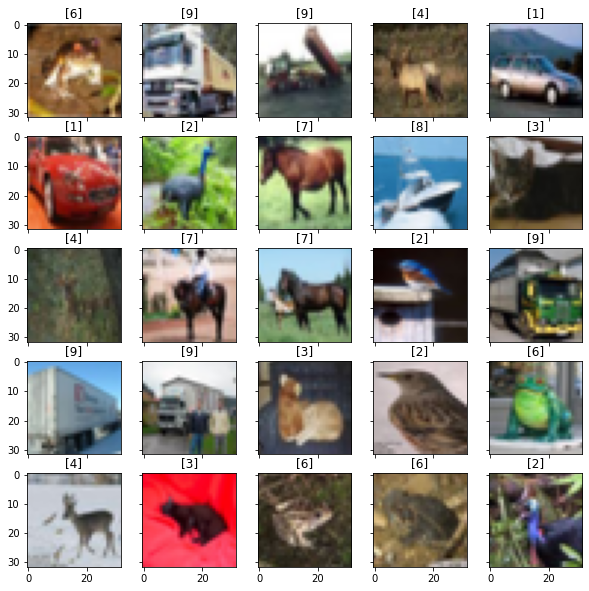

In [24]:
fig, ax = plt.subplots(5, 5, sharex = True, sharey=True, figsize=(10, 10))
c = 0
for i in range(0, 5):
    for j in range(0, 5):
        ax[i, j].imshow(x_train[c])
        ax[i, j].set_title(y_train[c])
        c+=1


<h1>Converting to Grayscale and Storing the Converted Images in a list</h1>

In [25]:
x_train_Gray = []
x_test_Gray = []
for i in range(x_train.shape[0]):
    img = x_train[i]
    x_train_Gray.append(rgb_gray(img))
print(len(x_train_Gray))

50000


In [26]:
for i in range(x_test.shape[0]):
    img = x_test[i]
    x_test_Gray.append(rgb_gray(img))
print(len(x_test_Gray))

10000


<h1>Image Preprocessing</h1>

In [27]:
# Converting the list to numpy array
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

# Reshaping the array to add the channel dimension, reshaping both colored and gray images - feature and target
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim, img_dim, 1)
input_shape = (img_dim, img_dim, 1)
lat_dim = 100



<h1>Normalising the pixels over the range[0-1]</h1>

In [28]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_Gray = x_train_Gray.astype('float32') / 255
x_test_Gray = x_test_Gray.astype('float32') / 255

<h1>Example of the Sample Image converted</h1>

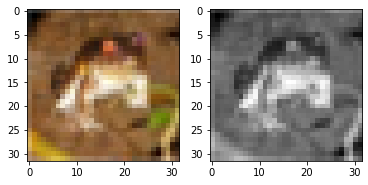

In [29]:
iml = x_train[0]
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(iml)
im2 = rgb_gray(iml)
ax[1].imshow(im2, cmap='gray')

<H1>Initialising the Encoder Model</H1>

In [30]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs
x = Conv2D(64, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2D(128, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2D(256, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(lat_dim, name = 'latent_vector')(x)
encoder = Model(inputs, latent, name = 'encoder_model')
encoder.summary()


Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 100)               409700    
                                                                 
Total params: 779,364
Trainable params: 779,364
Non-t

2022-11-06 23:28:59.127948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<H1>Initialising the Decoder Model</H1>

In [31]:
latent = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(256, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), activation = 'relu', strides = 2, padding = 'same')(x)
outputs = Conv2DTranspose(channels, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)
decoder = Model(latent, outputs, name = 'decoder_model')
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)     

<h1>Initialising the auto-encoder</h1>

In [32]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder_model')
autoencoder.summary()

Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 100)               779364    
                                                                 
 decoder_model (Functional)  (None, 32, 32, 3)         1374339   
                                                                 
Total params: 2,153,703
Trainable params: 2,153,703
Non-trainable params: 0
_________________________________________________________________


<h1>Learning rate plateau and scheduling</h1>

In [33]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_loss', factor = np.sqrt(0.1), cooldown = 0, patience = 5, min_lr = 0.5e-6)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Creating a directory for saving the model
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print(filepath)

# Checkpoint and learning rate scheduling callbacks
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [lr_reducer, checkpoint]

/Users/samridhagarwal/Desktop/Image-Colorization-master/saved_models/keras_cifar10_trained_model.h5


In [34]:
# Using the desired optimizer and loss function
autoencoder.compile(loss = 'mse', optimizer = 'adam', metrics=['accuracy'])

# fit the model
history = autoencoder.fit(x_train_Gray, x_train, 
validation_data = (x_test_Gray, x_test), 
epochs = 50, batch_size = 32, callbacks = callbacks)

x_decoded = autoencoder.predict(x_test_Gray)
autoencoder.save('autoencoder.h5')


Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.4740
Epoch 1: val_loss improved from inf to 0.01187, saving model to /Users/samridhagarwal/Desktop/Image-Colorization-master/saved_models/keras_cifar10_trained_model.h5
1563/1563 [==============================] - 175s 111ms/step - loss: 0.0166 - accuracy: 0.4740 - val_loss: 0.0119 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.4981
Epoch 2: val_loss improved from 0.01187 to 0.01027, saving model to /Users/samridhagarwal/Desktop/Image-Colorization-master/saved_models/keras_cifar10_trained_model.h5
1563/1563 [==============================] - 176s 112ms/step - loss: 0.0109 - accuracy: 0.4981 - val_loss: 0.0103 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.5045
Epoch 3: val_loss improved from 0.01027 to 0.00993, saving model to /Users

<h1>Comparing Colored test images to original images</h1>

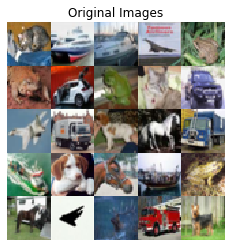

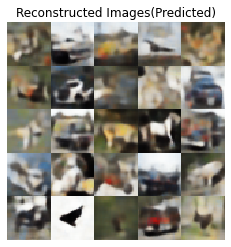

In [36]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Images')
plt.imshow(imgs, interpolation='none')
plt.show()
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Reconstructed Images(Predicted)')
plt.imshow(imgs, interpolation='none')
plt.show()


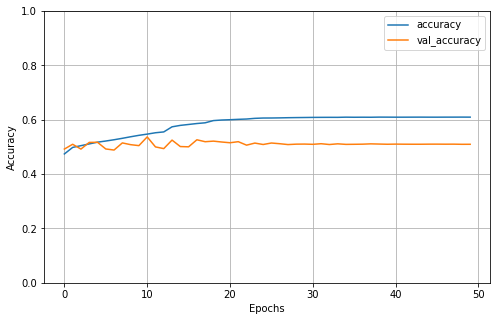

In [43]:
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


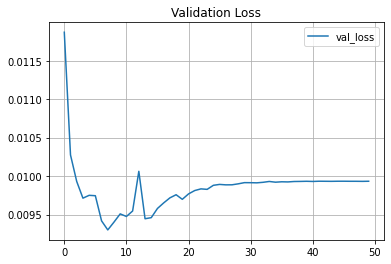

In [41]:
df[['val_loss']].plot()
plt.grid(True)
plt.title('Validation Loss')
plt.show()

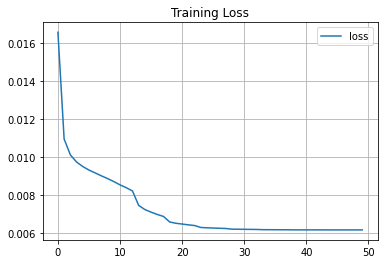

In [38]:
df[['loss']].plot()
plt.grid(True)
plt.title('Training Loss')
plt.show()